In [30]:
import os
import sys
import pickle
import time

from copy import deepcopy

from cnp.experiment import WorkingDirectory

from cnp.cnp import GaussianNeuralProcess, StandardConvGNP
from cnp.lnp import StandardConvNP
from cnp.architectures import UNet

from cnp.cov import (
    OutputLayer,
    GaussianLayer,
    MeanFieldGaussianLayer,
    InnerprodGaussianLayer,
    KvvGaussianLayer,
    LogLogitCopulaLayer,
    ExponentialCopulaLayer
)

import numpy as np
import matplotlib.pyplot as plt

import torch

from cnp.cnp import StandardConvGNP

import torch
import torch.nn as nn

from torch.distributions import (
    Normal,
    MultivariateNormal,
    LowRankMultivariateNormal
)

root = '/scratches/cblgpu07/em626/kernelcnp/kernelcnp/experiments/predator-prey'

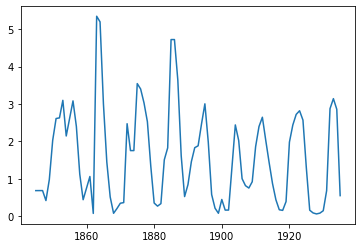

In [31]:
year = np.load(f'{root}/data/year.npy')
hare = np.load(f'{root}/data/hare.npy')
lynx = np.load(f'{root}/data/lynx.npy')

plt.plot(year, hare / 100 * (7 / 2))
# plt.plot(year, lynx)
plt.show()

In [32]:
idx_ctx = np.where(np.logical_or(year < 1900, year > 1920))
idx_trg = np.where(np.logical_and(year >= 1900, year <= 1920))

true_task = [{
    'x_context' : torch.tensor(year[idx_ctx])[None, :, None],
    'y_context' : torch.tensor(hare[idx_ctx])[None, :, None] / 100 * (7 / 2),
    'x_target' : torch.tensor(year[idx_trg])[None, :, None],
    'y_target' : torch.tensor(hare[idx_trg])[None, :, None] / 100 * (7 / 2)
}]

In [33]:
args_data = 'sim-pred-prey-16-50-100-100-0'
args_cov_type = 'meanfield'
args_noise_type = 'homo'
args_marginal_type = 'exponential'
args_model = 'convGNP'
args_num_basis_dim = 32

args_seed = 0
args_learning_rate = 5e-4
args_weight_decay = 0.
args_validate_every = 1
args_jitter = 1e-4

In [34]:
# Set seed
np.random.seed(args_seed)
torch.manual_seed(args_seed)

# root = '/Users/stratis/repos/kernelcnp/kernelcnp/experiments/predator-prey'

# Working directory for saving results
experiment_name = os.path.join(f'{root}',
                               f'results',
                               f'{args_data}',
                               f'models',
                               f'{args_model}',
                               f'{args_cov_type}',
                               f'{args_noise_type}',
                               f'{args_marginal_type}',
                               f'seed-{args_seed}')
working_directory = WorkingDirectory(root=experiment_name)

# Data directory for loading data
data_root = os.path.join(f'{root}',
                         f'simulated-data',
                         f'{args_data}')
data_directory = WorkingDirectory(root=data_root)
    
file = open(working_directory.file('data_location.txt'), 'w')
file.write(data_directory.root)
file.close()

# =============================================================================
# Load data 
# =============================================================================
    
file = open(data_directory.file('train-data.pkl'), 'rb')
data_train = pickle.load(file)
file.close()

file = open(data_directory.file('valid-data.pkl'), 'rb')
data_val = pickle.load(file)
file.close()

Root: /scratches/cblgpu07/em626/kernelcnp/kernelcnp/experiments/predator-prey/results/sim-pred-prey-16-50-100-100-0/models/convGNP/meanfield/homo/exponential/seed-0
Root: /scratches/cblgpu07/em626/kernelcnp/kernelcnp/experiments/predator-prey/simulated-data/sim-pred-prey-16-50-100-100-0


In [35]:
# =============================================================================
# Training epoch helper
# =============================================================================

def train(data,
          model,
          optimiser,
          log_every,
          device,
          writer,
          iteration):
    
    for step, batch in enumerate(data):

        nll = model.loss(batch['x_context'][:, :, None].to(device),
                         batch['y_context'][:, 0, :, None].to(device) / 100 + 1e-2,
                         batch['x_target'][:, :, None].to(device),
                         batch['y_target'][:, 0, :, None].to(device) / 100 + 1e-2)
        
        encoder_scale = torch.exp(model.encoder.sigma).detach().cpu().numpy().squeeze()
        decoder_scale = torch.exp(model.decoder.sigma).detach().cpu().numpy().squeeze()

        if step % log_every == 0:
            print(f"Training   neg. log-lik: {nll:.2f}, "
                  f"Encoder/decoder scales {encoder_scale:.3f} "
                  f"{decoder_scale:.3f}")

        # Compute gradients and apply them
        nll.backward()
        optimiser.step()
        optimiser.zero_grad()
        
        iteration = iteration + 1
        
    return iteration


# =============================================================================
# Validation helper
# =============================================================================


def validate(data,
             true_data,
             model,
             device,
             writer,
             latent_model):
    
    # Lists for logging model's training NLL and oracle NLL
    nll_list = []
    nll_true_list = []
    oracle_nll_list = []
    
    # If training a latent model, set the number of latent samples accordingly
    loss_kwargs = {'num_samples' : args_np_val_samples} \
                  if latent_model else {}
    
    with torch.no_grad():
        for step, batch in enumerate(data):
            
            nll = model.loss(batch['x_context'][:, :, None].to(device),
                             batch['y_context'][:, 0, :, None].to(device) / 100 + 1e-2,
                             batch['x_target'][:, :, None].to(device),
                             batch['y_target'][:, 0, :, None].to(device) / 100 + 1e-2,
                             **loss_kwargs)
            
            nll_list.append(nll.item())
            
        for step, batch in enumerate(true_data):
            
            nll_true = model.loss(true_data['x_context'].to(device),
                                  true_data['y_context'].to(device) / 100 + 1e-2,
                                  true_data['x_target'].to(device),
                                  true_data['y_target'].to(device) / 100 + 1e-2,
                                  **loss_kwargs)
            
            nll_true_list.append(nll.item())

    mean_nll = np.mean(nll_list)
    std_nll = np.var(nll_list)**0.5
    
    mean_true_nll = np.mean(nll_true_list)
    std_true_nll = np.var(nll_true_list)**0.5

    # Print validation loss and oracle loss
    print(f"Validation neg. log-lik: "
          f"{mean_nll:.2f}")
    
    print(f"True data  neg. log-lik: "
          f"{mean_true_nll:.2f}")

    return mean_nll, std_nll, mean_true_nll, std_true_nll

In [36]:
# =============================================================================
# Create model
# =============================================================================
    
# Set device
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    
use_cpu = False
device = torch.device('cpu') if use_cpu else torch.device('cuda')

cov_types = {
    'meanfield' : MeanFieldGaussianLayer,
    'innerprod' : InnerprodGaussianLayer,
    'kvv'       : KvvGaussianLayer
}

if args_cov_type == 'meanfield':
    output_layer = MeanFieldGaussianLayer(jitter=args_jitter)
    
else:
    output_layer = cov_types[args_cov_type](num_embedding=args_num_basis_dim,
                                            noise_type=args_noise_type,
                                            jitter=args_jitter)

if args_marginal_type == 'loglogit':
    output_layer = LogLogitCopulaLayer(gaussian_layer=output_layer,
                                       device=device)
if args_marginal_type == 'exponential':
    output_layer = ExponentialCopulaLayer(gaussian_layer=output_layer,
                                          device=device)
    
# Create model architecture
if args_model == 'convGNP':
    model = StandardConvGNP(input_dim=1, output_layer=output_layer)
    
elif args_model == 'convNP':
    model = StandardConvNP(input_dim=1,
                           num_samples=args_np_loss_samples)
    
else:
    raise ValueError(f'Unknown model {args_model}.')

model.to(device)

latent_model = args_model == 'convNP'

print(f'{args_data} '
      f'{args_model} '
      f'{args_cov_type} '
      f'{args_noise_type} '
      f'{args_marginal_type} '
      f'{args_num_basis_dim}: '
      f'{model.num_params}')

TypeError: __init__() got an unexpected keyword argument 'constrain_variance'

In [ ]:
# =============================================================================
# Train or test model
# =============================================================================

# Number of epochs between validations
train_iteration = 0
log_every = 100

# Create optimiser
optimiser = torch.optim.Adam(model.parameters(),
                         args_learning_rate,
                         weight_decay=args_weight_decay)

# Run the training loop, maintaining the best objective value
best_nll = np.inf

epochs = len(data_train)

start_time = time.time()
for epoch in range(epochs):

    print('\nEpoch: {}/{}'.format(epoch+1, epochs))

    if False: # epoch % args_validate_every == 0:

        valid_epoch = data_val[epoch // args_validate_every]

        # Compute negative log-likelihood on validation data
        val_nll, _,  = validate(valid_epoch,
                                model,
                                device,
                                None,
                                latent_model)

#         # Log information to tensorboard
#         writer.add_scalar('True data log-lik.',
#                           -true_nll,
#                           epoch)

#         # Log information to tensorboard
#         writer.add_scalar('Validation log-lik.',
#                           -val_nll,
#                           epoch)

        # Update the best objective value and checkpoint the model
        is_best, best_obj = (True, val_nll) if val_nll < best_nll else \
                            (False, best_nll)


    train_epoch = data_train[epoch]

    # Compute training negative log-likelihood
    train_iteration = train(train_epoch,
                            model,
                            optimiser,
                            log_every,
                            device,
                            None,
                            train_iteration)

#     save_checkpoint(working_directory,
#                     {'epoch'         : epoch + 1,
#                      'state_dict'    : model.state_dict(),
#                      'best_acc_top1' : best_obj,
#                      'optimizer'     : optimiser.state_dict()},
#                     is_best=is_best,
#                     epoch=epoch)